In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import requests

ticker = 'vist'
ticker = ticker.upper()
today = dt.date.today()

In [ ]:
def get_ema(ticker, today = today):
    ema_values = []
    for short_ema in range(2, 30):
        for long_ema in range(20, 50):
            if short_ema < long_ema:
                data = yf.download(tickers = ticker, start = '2010-1-1', end = f'{today.year}-{today.month}-{today.day}', auto_adjust = True)
                data[f'EMA_{short_ema}'] = data['Close'].ewm(span = short_ema).mean()
                data[f'EMA_{long_ema}'] = data['Close'].ewm(span = long_ema).mean()
                data['Ratio'] = (data[f'EMA_{short_ema}'] / data[f'EMA_{long_ema}']).shift()
                data['State'] = data.apply(lambda row: 'In' if row['Ratio'] >= 1 else 'Out', axis = 1)
                data['Yield'] = data['Close'].pct_change() + 1

                in_asset = data[data['State'] == 'In']
                cumulative_yield = (in_asset['Yield'].prod() - 1)
                start_date = in_asset.index[0].date()
                days = (today - start_date).days
                annual_yield = round((((1 + cumulative_yield) ** (365 / days)) - 1) * 100, 2)
                ema_values.append([short_ema, long_ema, annual_yield])

    return ema_values

ema_values = get_ema(ticker = ticker)
print(ema_values)

In [ ]:
def create_ema_df(data):
    ema_columns = ['short_ema', 'long_ema', 'yield']
    ema_df = pd.DataFrame(data, columns = ema_columns)
    ema_df.sort_values(by = 'yield', ascending = False, inplace = True)
    ema_df = ema_df.iloc[:10, :]
    
    return ema_df

ema_df = create_ema_df(data = ema_values)
ema_df

In [ ]:
def mean_emas(data, ticker, today = today):
    mean_short_ema = int(data['short_ema'].mean())
    mean_long_ema = int(data['long_ema'].mean())
    mean_yield = int(data['yield'].mean())
    data = yf.download(tickers = ticker, start = '2010-1-1', end = f'{today.year}-{today.month}-{today.day}', auto_adjust = True)
    data[f'EMA_{mean_short_ema}'] = data['Close'].ewm(span = mean_short_ema).mean()
    data[f'EMA_{mean_long_ema}'] = data['Close'].ewm(span = mean_long_ema).mean()
    data['Ratio'] = (data[f'EMA_{mean_short_ema}'] / data[f'EMA_{mean_long_ema}']).shift()
    data['State'] = data.apply(lambda row: 'In' if row['Ratio'] >= 1 else 'Out', axis = 1)
    data['Action'] = ['Buy' if (data['State'][i] == 'In') and (data['State'][i - 1] == 'Out') else 'Sell' if (data['State'][i] == 'Out') and (data['State'][i - 1] == 'In') else 'Pass' for i in range(len(data))]

    sell_signals = data[data['Action'] == 'Sell']
    buy_signals = data[data['Action'] == 'Buy']
    
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize = (40, 16))
    ax.scatter(x = sell_signals.index, y = sell_signals['Close'], color = 'red', marker = 'v', label = 'Sell', s = 200)
    ax.scatter(x = buy_signals.index, y = buy_signals['Close'], color = 'green', marker = '^', label = 'Buy', s = 200)
    sns.lineplot(data = data, x = data.index, y = data['Close'], label = 'Stock Price')
    sns.lineplot(data = data, x = data.index, y = data[f'EMA_{mean_short_ema}'], label = f'Short EMA ({mean_short_ema})')
    sns.lineplot(data = data, x = data.index, y = data[f'EMA_{mean_long_ema}'], label = f'Long EMA ({mean_long_ema})')
    plt.legend(fontsize = 'large')
    plt.title(f'Rendimiento acumulado anual de {ticker}: {mean_yield}%')
    plt.show()

    return data

mean_emas_data = mean_emas(data = ema_df, ticker = ticker)

In [2]:
def sp_companies():
    url = 'https://www.slickcharts.com/sp500'
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url = url, headers = headers)
    sp_data = pd.read_html(r.text)[0][['Company', 'Symbol']]

    return sp_data

sp_companies()

,Company,Symbol
0,Microsoft Corp,MSFT
1,Apple Inc.,AAPL
2,Nvidia Corp,NVDA
3,Amazon.com Inc,AMZN
4,Alphabet Inc. Class A,GOOGL
...,...,...
498,V.F. Corporation,VFC
499,Ralph Lauren Corporation,RL
500,"Mohawk Industries, Inc.",MHK
501,Fox Corporation Class B,FOX


In [3]:
def stock_correlations(ticker = ticker, sp_companies = sp_companies(), today = today):
    tickers = sp_companies['Symbol'].to_list()
    tickers = [s.replace('.', '-') for s in tickers]
    if ticker in tickers:
        tickers
    else:
        tickers.append(ticker)

    data = yf.download(tickers = tickers, start = '2010-1-1', end = f'{today.year}-{today.month}-{today.day}', auto_adjust = True)['Close']
    data = data.pct_change()
    correlation = data.corr()[ticker]
    correlation = correlation.sort_values(ascending = False)
    correlation = correlation.iloc[1:11]
    series_df = correlation.reset_index()
    series_df.columns = ['Symbol', 'Correlation']
    correlation = pd.merge(left = series_df, right = sp_companies, how = 'left', left_on= 'Symbol', right_on = 'Symbol')
    correlation.rename(columns = {'Company': 'Name'}, inplace = True)
    correlation.set_index('Symbol', inplace = True)
    
    return correlation

best_stocks = stock_correlations()
best_stocks

[*********************100%%**********************]  504 of 504 completed


,Correlation,Name
Symbol,,
HAL,0.544897,Halliburton Company
SLB,0.537702,Schlumberger Limited
MRO,0.535947,Marathon Oil Corporation
PXD,0.530499,Pioneer Natural Resource Co.
DVN,0.529797,Devon Energy Corporation
EOG,0.521111,"Eog Resources, Inc."
COP,0.514173,Conocophillips
HES,0.509573,Hess Corporation
FANG,0.509021,"Diamondback Energy, Inc."


In [4]:
def commodities():
    url = 'https://finance.yahoo.com/commodities/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAACxVMXbUY4TFerSQ8G61bHBLfBhaXr7kfzXI_kTs9WfeaaeqQ_x_RHqaiaf9mZxlSxo28LHouGXWcFWxWnhDnotI6yS50Efs0VyFDt_dHPHraJ4h9S9gkI1t31lN2tTfNPGrYPmmSjv4ekDEoqk72McrbL7QSs1mYtRaKsX7SB4A'
    headers = {
        "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
        "X-Requested-With": "XMLHttpRequest"
    }
    r = requests.get(url = url, headers = headers)
    commodities = pd.read_html(r.text)[0]
    commodities = commodities.loc[:, ['Symbol', 'Name']]

    return commodities

commodities()

,Symbol,Name
0,ES=F,S&P Futures
1,YM=F,Dow Futures
2,NQ=F,Nasdaq Futures
3,RTY=F,Russell 2000 Futures
4,ZB=F,"U.S. Treasury Bond Futures,Mar-"
5,ZN=F,"10-Year T-Note Futures,Mar-2024"
6,ZF=F,Five-Year US Treasury Note Futu
7,ZT=F,"2-Year T-Note Futures,Mar-2024"
8,GC=F,Gold
9,MGC=F,"Micro Gold Futures,Apr-2024"


In [5]:
def commodities_correlations(ticker = ticker, commodities = commodities(), today = today):
    tickers = commodities['Symbol'].to_list()
    tickers.append(ticker)
    data = yf.download(tickers = tickers, start = '2010-1-1', end = f'{today.year}-{today.month}-{today.day}', auto_adjust = True)['Close']
    data = data.pct_change()
    correlation = data.corr()
    correlation = correlation[ticker]
    correlation = correlation.sort_values(ascending = False)
    correlation = correlation.iloc[1:4]
    df_correlation = correlation.reset_index()
    df_correlation.columns = ['Symbol', 'Correlation']
    correlation = pd.merge(left = df_correlation, right = commodities, how = 'left', left_on = 'Symbol', right_on = 'Symbol')
    correlation = correlation.loc[:, ['Symbol', 'Correlation', 'Name']]
    correlation.set_index('Symbol', inplace = True)

    return correlation

best_commodities = commodities_correlations()
best_commodities

[*********************100%%**********************]  38 of 38 completed


,Correlation,Name
Symbol,,
RTY=F,0.434095,Russell 2000 Futures
YM=F,0.420458,Dow Futures
BZ=F,0.409422,Brent Crude Oil Last Day Financ


In [6]:
def best_correlations(stocks = best_stocks, commodities = best_commodities):
    data = pd.concat(objs = [stocks, commodities])
    data.sort_values(by = 'Correlation', ascending = False, inplace = True)

    return data

best_correlations()

,Correlation,Name
Symbol,,
HAL,0.544897,Halliburton Company
SLB,0.537702,Schlumberger Limited
MRO,0.535947,Marathon Oil Corporation
PXD,0.530499,Pioneer Natural Resource Co.
DVN,0.529797,Devon Energy Corporation
EOG,0.521111,"Eog Resources, Inc."
COP,0.514173,Conocophillips
HES,0.509573,Hess Corporation
FANG,0.509021,"Diamondback Energy, Inc."


[*********************100%%**********************]  14 of 14 completed


,APA,BZ=F,COP,DVN,EOG,FANG,HAL,HES,MRO,PXD,RTY=F,SLB,VIST,YM=F
Date,,,,,,,,,,,,,,
2019-07-26,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-07-29,97.492676,100.393949,99.046784,99.921667,99.561046,97.784102,96.309161,100.250700,98.181824,98.437486,99.342395,98.000490,109.890105,100.180485
2019-07-30,100.710424,101.985506,101.293611,105.246679,102.099870,100.823605,100.738200,103.626933,102.763637,101.628831,100.373065,98.850289,110.989011,100.055251
2019-07-31,102.047648,102.694609,100.561688,105.716531,101.850737,101.411896,99.869736,108.373752,102.327242,101.739390,99.696488,99.900040,110.109891,98.917087
2019-08-01,100.794003,102.726132,100.085099,98.512130,96.179834,95.499549,94.051233,106.401476,98.399988,94.015328,98.109388,96.250954,103.296695,97.767874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22,139.264017,126.158208,216.996893,210.142202,163.678580,178.261143,161.598616,246.712707,172.311678,202.648824,126.228267,142.064038,347.142844,140.701315
2024-01-23,139.898896,125.354561,216.856325,210.754558,163.279153,177.709722,165.681991,245.960647,173.007731,205.129392,125.798293,141.335210,348.901084,140.296144
2024-01-24,142.257000,126.126697,220.229959,212.387522,165.823676,179.739411,172.863121,251.171380,174.709188,208.705169,124.704391,144.839158,353.516449,139.890972


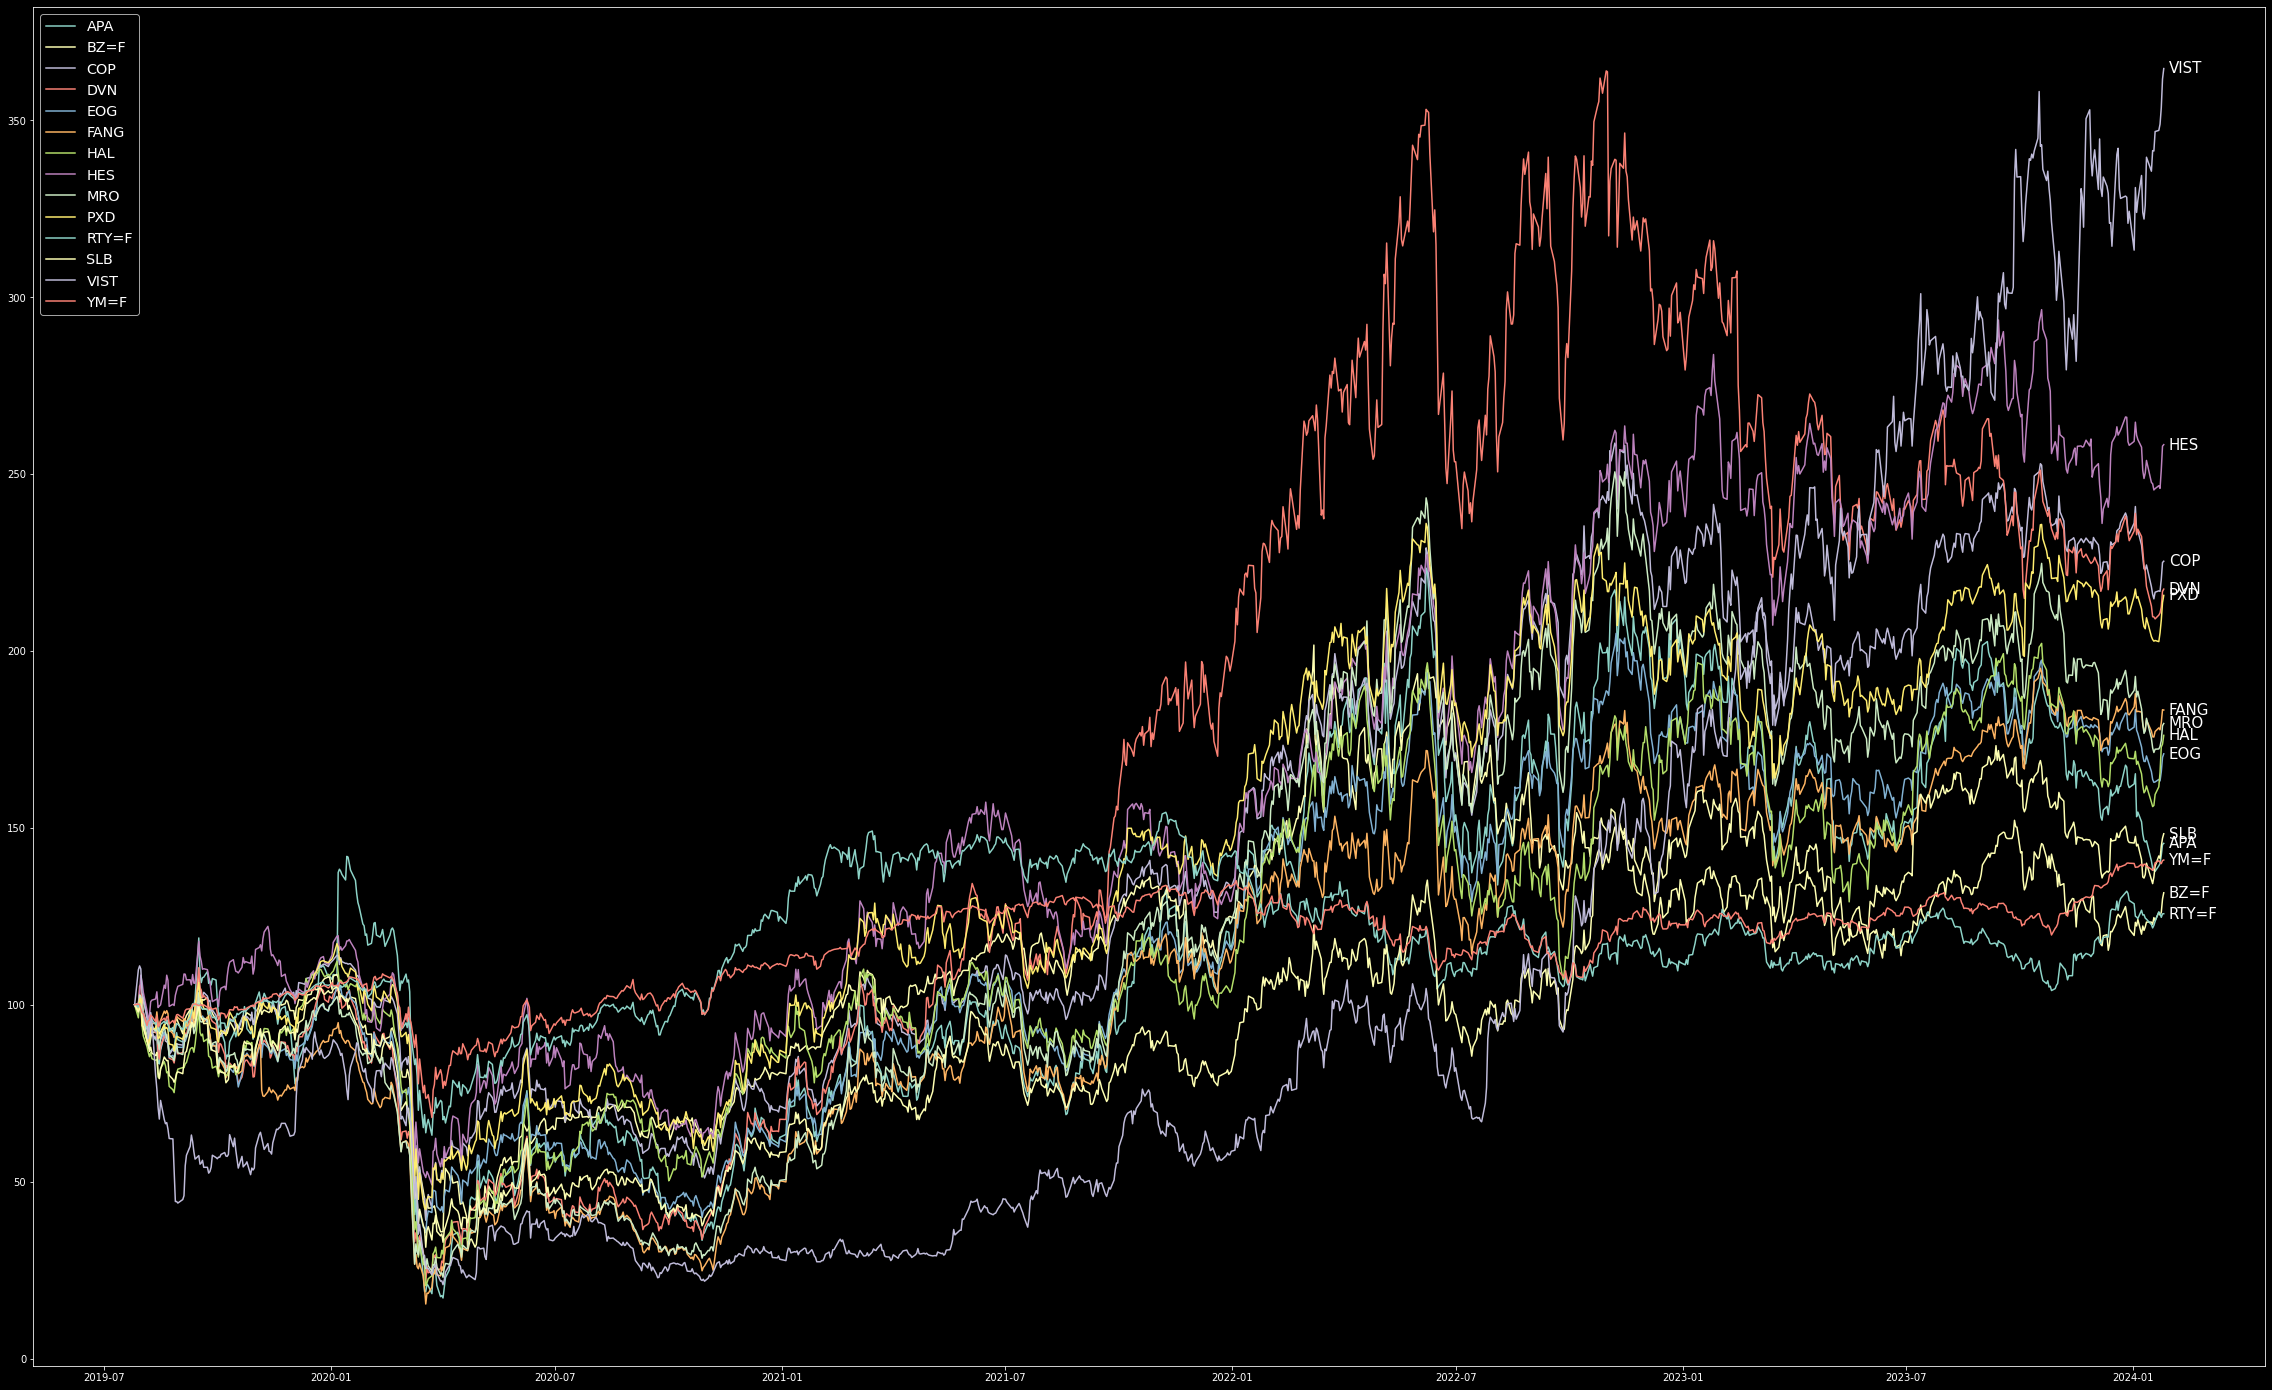

In [22]:
def graphic_correlations(data = best_correlations(), ticker = ticker, today = today):
    tickers = data.index.to_list()
    tickers.append(ticker)
    values = yf.download(tickers = tickers, start = '2010-1-1', end = f'{today.year}-{today.month}-{today.day}', auto_adjust = True)['Close']
    values.dropna(inplace = True)
    values = values.divide(values.iloc[0]) * 100

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize = (40, 25))
    for ticker in values:
        plt.plot(values.index, values[ticker], label = f'{ticker}')
        plt.annotate(ticker, xy=(values.index[-1], values[ticker].iloc[-1]), xytext=(5,0), textcoords='offset points', ha='left', va='center', color='white', size = 15)
    plt.legend(fontsize = 'x-large')
    return values

graphic_correlations()